In [20]:
# Standard Libraries
import copy
import itertools
import os
import time
from tempfile import TemporaryDirectory

# 3rd Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm
import torch
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from tqdm import tqdm

In [21]:
# FOR USE ON GOOGLE COLAB

# from google.colab import drive
# drive.mount('/content/drive') # Mounts it to YOUR drive. Nishanth and Chad, you will have to add a shortcut to dataset-resized.
# # # Dataset-realized is in the folder that was shared.

# # # Path to the dataset folder
# folder_path = '/content/drive/My Drive/dataset-resized' # All images are 512 x 384
# # #folder_path = '/content/drive/My Drive/24-782: ML and AI for Engineers - Project/4- Code/dataset-resized'  #Chad path

# # #folder path for Nishanth
# # folder_path = '/content/drive/My Drive/Courses/24-782: ML and AI for Engineers - Project/Code/dataset-resized'

folder_path = '../../data/dataset-resized' # My local path
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1' # for timm

This is used to prepare the data for labeling.

In [22]:
def prepare_data(data_dir):
    """
    Prepares the dataset for training/testing by organizing image paths and labels.

    Parameters:
    - data_dir (str): Directory containing the dataset, organized into subdirectories
      for each category.

    Returns:
    - tuple: Two lists containing the image file paths and corresponding labels.
    """

    # Define the categories of the dataset
    categories = ['Trash', 'Plastic', 'Paper', 'Metal', 'Glass', 'Cardboard']

    # Lists to hold the paths of the images and their labels
    image_paths = []
    labels = []  # Numerical labels: 0 for Trash, 1 for Plastic, etc.

    # Enumerate over categories to label the images accordingly
    for label, category in enumerate(categories):
            try:
                # Construct the directory path for the current category
                category_dir = os.path.join(data_dir, category)

                # Iterate through each file in the category directory
                for file in os.listdir(category_dir):
                    # Check if the file is an image
                    if file.endswith('.jpg') or file.endswith('.png'):
                        image_paths.append(os.path.join(category_dir, file))
                        labels.append(label)  # Assign the label to this image
            except Exception as e:
                print(f"Failed to process category {category} due to error: {e}")
                continue
    return image_paths, labels

In [23]:
image_paths, labels = prepare_data(folder_path)

In [24]:
class CustomDataset(Dataset):
    """
    A custom dataset class that extends PyTorch's Dataset class for image loading and preprocessing.

    Attributes:
    - image_paths (list): List of paths to the images.
    - labels (list): List of labels corresponding to the images.
    - transform (callable, optional): Optional transform to be applied on a sample.
    """

    def __init__(self, image_paths, labels, transform=None):
        """
        Initializes the dataset with images and labels.

        Parameters:
        - image_paths (list): List of paths to the images.
        - labels (list): List of labels for the images.
        - transform (callable, optional): Optional transform to apply on images.
        """

        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """

        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Retrieves an image and its label from the dataset at the specified index.

        Parameters:
        - index (int): Index of the image and label to return.

        Returns:
        - tuple: A tuple containing the image and its label.
        """

        image_path = self.image_paths[index]
        # Load the image as a PIL Image
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[index], dtype=torch.long)
        return image, label

In [25]:
# Function for displaying an image, currently not used in the main workflow
def imshow(inp, title=None):
    """
    Displays an image with an optional title.

    Parameters:
    - inp (Tensor): The image tensor to display.
    - title (str, optional): Optional title to display above the image.
    """

    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to update the plot

In [26]:
# Split the data into training and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.15, random_state=0)

# Split the data into training, validation, and test sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.175, random_state=0)  # 0.175 x 0.85 ~= 0.15

# So, the data is split into 70% training, 15% validation, and 15% testing

In [27]:
# Normalization parameters found to be optimal for CIFAR dataset; may need adjustment for other datasets
normalization = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# Define the training data transformations
training_transform = transforms.Compose([
    transforms.Resize(256, antialias=True),  # Resize images to 256x256, with antialiasing
    transforms.RandomCrop(224),  # Crop randomly to 224x224 for data augmentation
    transforms.RandomRotation(20),  # Rotate images up to 20 degrees for data augmentation
    transforms.RandomHorizontalFlip(0.1),  # Horizontally flip images with a probability of 0.1 for data augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Randomly adjust color settings
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),  # Randomly adjust sharpness for data augmentation
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(*normalization),  # Normalize images using the specified mean and std dev
])

# Define the validation and test data transformations (simpler than training transformations)
transform = transforms.Compose([
    transforms.Resize(256, antialias=True),  # Resize images to 256x256, with antialiasing
    transforms.CenterCrop(224),  # Center crop images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(*normalization),  # Normalize images using the specified mean and std dev
])


In [28]:
def initialize_model(output_classes=6):
    """
    Initializes the EfficientNet-B5 model with a custom final layer for the given number of output classes.

    Parameters:
    - output_classes (int): The number of classes for the final output layer.

    Returns:
    - model (torch.nn.Module): The modified model based on the pre-trained EfficientNetB5 feature representation.
    """

    # Load a pre-trained EfficientNet-B5 model from the timm library
    model = timm.create_model('efficientnet_b5', pretrained=True)

    # Freeze all the parameters in the model to prevent them from being updated during training
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of input features to the final fully connected layer
    # The classifier layer is the final layer in EfficientNet models
    in_features = model.classifier.in_features

    # Replace the final classifier layer with a new one that has the desired number of output classes
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 512),  # Reduce dimension from in_features to 512 (from 1280 in this case)
        nn.ReLU(),                    # Apply ReLU activation function
        nn.Linear(512, output_classes)  # Final layer with 'output_classes' number of outputs
    )

    return model

def evaluate_model(model, dataloader, loss_fun, device):
    """
    Evaluates the model's performance on a given dataset.

    Parameters:
    - model: The neural network model to evaluate.
    - dataloader: The DataLoader containing the dataset for evaluation.
    - loss_fun: The loss function used to compute the model's loss.
    - device: The device (CPU or CUDA) on which the computations will be performed.

    Returns:
    - A tuple of average loss and accuracy over the dataset.
    """

    model.eval()  # Set the model to evaluation mode    test_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    with torch.no_grad():  # No gradients needed for evaluation
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)  # Move data to the same device as the model

            pred = model(x)
            _, predicted_classes = torch.max(pred, 1)
            correct_predictions = (predicted_classes == y).float()

            loss = loss_fun(pred, y.long())  # Ensure consistent data type
            val_loss += loss.item()
            val_acc += correct_predictions.sum().item() / y.size(0)

        val_loss /= len(dataloader)
        val_acc /= len(dataloader)

    return val_loss, val_acc

def misclassified_labels(model, dataloader, device):
    """
    Identifies misclassified samples in the given dataset.

    Parameters:
    - model: The neural network model to evaluate.
    - dataloader: The DataLoader containing the dataset for evaluation.
    - device: The device (CPU or CUDA) on which the computations will be performed.

    Returns:
    - A list of tuples where each tuple contains the image path, actual label, and predicted label.
    """

    model.eval()  # Set the model to evaluation mode
    misclassified = []

    with torch.no_grad():  # No gradients needed for evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Identify misclassified labels
            mismatches = predicted != labels
            for idx in torch.where(mismatches)[0]:
                actual_label = labels[idx].item()
                predicted_label = predicted[idx].item()
                image_path = dataloader.dataset.image_paths[idx]  # Assuming dataset has 'image_paths' attribute
                misclassified.append((image_path, actual_label, predicted_label))

    return misclassified

# Usage example
num_classes = 6  # Define the number of output classes you need
example_model = initialize_model(num_classes)
print(example_model)


EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

In [29]:
labels_mapping = {'Trash': 0, 'Plastic': 1, 'Paper': 2, 'Metal': 3, 'Glass': 4, 'Cardboard': 5}
datasets_by_label = {}
data_loaders_by_label = {}

for label_name, label_id in labels_mapping.items():
    # Filter indices for the current label
    indices = [i for i, label in enumerate(labels) if label == label_id]

    # Use the indices to create a Subset
    subset = Subset(CustomDataset(image_paths, labels, transform=transform), indices)

    # Store the subset using the label_name as key
    datasets_by_label[label_name] = subset

    # Create a DataLoader for the current label's dataset
    data_loader = DataLoader(subset, batch_size=32, num_workers=1, shuffle=False)

    # Store the DataLoader using the label_name as key
    data_loaders_by_label[label_name] = data_loader

for label_name, subset in datasets_by_label.items():
    print(f"\nExamples from class: {label_name}")

    # Get the first few indices from the subset.indices
    example_indices = subset.indices[:5]  # Adjust the number of examples as needed

    for idx in example_indices:
        print(f"Path: {image_paths[idx]}, Label ID: {labels[idx]}")


Examples from class: Trash
Path: ../../data/dataset-resized\Trash\trash1.jpg, Label ID: 0
Path: ../../data/dataset-resized\Trash\trash10.jpg, Label ID: 0
Path: ../../data/dataset-resized\Trash\trash100.jpg, Label ID: 0
Path: ../../data/dataset-resized\Trash\trash101.jpg, Label ID: 0
Path: ../../data/dataset-resized\Trash\trash102.jpg, Label ID: 0

Examples from class: Plastic
Path: ../../data/dataset-resized\Plastic\plastic1.jpg, Label ID: 1
Path: ../../data/dataset-resized\Plastic\plastic10.jpg, Label ID: 1
Path: ../../data/dataset-resized\Plastic\plastic100.jpg, Label ID: 1
Path: ../../data/dataset-resized\Plastic\plastic101.jpg, Label ID: 1
Path: ../../data/dataset-resized\Plastic\plastic102.jpg, Label ID: 1

Examples from class: Paper
Path: ../../data/dataset-resized\Paper\paper1.jpg, Label ID: 2
Path: ../../data/dataset-resized\Paper\paper10.jpg, Label ID: 2
Path: ../../data/dataset-resized\Paper\paper100.jpg, Label ID: 2
Path: ../../data/dataset-resized\Paper\paper101.jpg, Label

In [30]:
def train(train_dataloader, val_dataloader, num_classes, N_epochs=10, lr=1e-5, step_size=15, gamma=0.9):
    """
    Trains and validates a model, saving the model with the best validation accuracy, and records the training and validation performance.

    Parameters:
    - train_dataloader (DataLoader): DataLoader for training data.
    - val_dataloader (DataLoader): DataLoader for validation data.
    - num_classes (int): Number of classes in the dataset.
    - N_epochs (int): Number of epochs to train for.
    - lr (float): Learning rate for the optimizer.
    - step_size (int): Step size for the learning rate scheduler.
    - gamma (float): Decay rate for the learning rate scheduler.

    Returns:
    - A dictionary containing the model with the best validation accuracy, training losses, training accuracies, validation losses, and validation accuracies.
    """

    # Set the device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # If a CUDA-capable device is detected, print its name
    if device.type == 'cuda':
        gpu_name = torch.cuda.get_device_name(0)
        print(f"NVIDIA Graphics Card: {gpu_name}")

    # Initialize the model and move it to the appropriate device
    model = initialize_model(num_classes)
    model.to(device)

    # Define the loss function and the optimizer
    loss_fun = nn.CrossEntropyLoss()
    loss_fun.to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=lr)

    # Define the learning rate scheduler
    lr_schedule = lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

    # Initialize lists to store the performance metrics
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    # Variable to keep track of the best validation accuracy
    best_acc = 0.0
    # Variable to store the model weights corresponding to the best validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())

    # Training loop
    for epoch in tqdm(range(N_epochs)):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_correct = 0
        total = 0

        # Iterate over the training data
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)  # Move data to the correct device
            pred = model(x)  # Forward pass: compute the model output
            loss = loss_fun(pred, y.long())  # Compute the loss
            optimizer.zero_grad()  # Zero the gradients to prevent accumulation
            loss.backward()  # Backward pass: compute the gradient of the loss with respect to model parameters
            optimizer.step()  # Update model parameters

            # Accumulate the training loss and correct predictions to calculate accuracy
            train_loss += loss.item()
            _, predicted = torch.max(pred, 1)
            train_correct += (predicted == y).sum().item()
            total += y.size(0)

        # Compute the average training loss and accuracy for the epoch
        train_loss /= len(train_dataloader)
        train_acc = train_correct / total
        training_losses.append(train_loss)
        training_accuracies.append(train_acc)

        # Validate the model
        val_loss, val_acc = evaluate_model(model, val_dataloader, loss_fun, device)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_acc)

        # Check if the current model is the best one based on validation loss
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Update the learning rate
        lr_schedule.step()

        # Print the performance metrics for the epoch
        print(f"Epoch {epoch+1}/{N_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Return the model and performance metrics
    return {
        "model": model,
        "training_losses": training_losses,
        "training_accuracies": training_accuracies,
        "validation_losses": validation_losses,
        "validation_accuracies": validation_accuracies
    }

In [31]:
# Create dataset objects for training, validation, and testing
train_dataset = CustomDataset(train_paths, train_labels, transform=training_transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=transform)
test_dataset = CustomDataset(test_paths, test_labels, transform=transform)

# Define the hyperparameter grid
learning_rates = [5e-5, 5e-4]  # CV learning rates
batch_sizes = [32]  # CV batch sizes
num_epochs_list = [20]  # CV number of epochs
step_sizes = [5, 20]  # CV step sizes

# Record the best performance and metrics
best_acc = 0
best_hyperparams = None
best_model_info = {}

# Record time for compute calculations later.
start_time = time.time()

# VERY IMPORTANT TO BE AWARE OF THE FLUCTUATIONS IN THE GPU UTILIZATION AND THE PEAK PERFORMANCE.
# IF THIS IS BEING RUN SOMEWHERE ELSE THIS MUST BE UPDATED.
# THESE VALUES ARE FOR THE NVIDIA GEFORCE RTX 3050 Ti ON NIKOLAJ'S LAPTOP. NOT UNIVERSAL AND ALSO THE AVERAGE UTALIZATION IS A GUESS FROM MY EXPERIENCE.
peak_performance_tflops = 9.76 # Hypothetical peak performance in TFLOP/s of NVIDIA GeForce RTX 3050 Ti
average_utilization = 0.20  # Assumed average (from my experience on task manager)

# Iterate over all combinations of hyperparameters
for lr, batch_size, num_epochs, step_size in itertools.product(learning_rates, batch_sizes, num_epochs_list, step_sizes):
    print(f"Training with lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}, step_size={step_size}")

    # Create data loaders for batching, shuffling, and iterating over the datasets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Train the model with the current set of hyperparameters
    results = train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_classes=6, N_epochs=num_epochs, lr=lr, step_size=step_size)
    model = results["model"]

    # Evaluate the model on the testing set
    loss_fun = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if device.type == 'cuda':
        gpu_name = torch.cuda.get_device_name(0)
        print(f"NVIDIA Graphics Card: {gpu_name}")

    test_loss, test_acc = evaluate_model(model, test_dataloader, loss_fun, device)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Save the model and metrics if it has the best accuracy so far on the testing set
    if test_acc > best_acc:
        best_acc = test_acc
        best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'num_epochs': num_epochs}
        best_model_info = {
            "state_dict": copy.deepcopy(model.state_dict()),
            "training_losses": results["training_losses"],
            "training_accuracies": results["training_accuracies"],
            "validation_losses": results["validation_losses"],
            "validation_accuracies": results["validation_accuracies"]
        }


end_time = time.time() # end time in seconds
total_time = end_time - start_time # total time in seconds
total_compute_units_tflops = peak_performance_tflops * average_utilization * total_time # total compute in TFLOP/s

# Convert TFLOPs to TFLOP-hours by dividing by the number of seconds in an hour
total_compute_units_tfloph = total_compute_units_tflops / 3600

print(f"Assuming peak performance of {peak_performance_tflops} TFLOP/s and average utilization of {average_utilization}:")
print(f"Total training time: {total_time} seconds")
print(f"Total compute units: {total_compute_units_tfloph} TFLOP-hours")

# Output the best performing set of hyperparameters based on the testing dataset
print(f"Best performing model on testing set: {best_hyperparams} with accuracy: {best_acc}")

# Save the best model and associated metrics
torch.save(best_model_info, 'EfficientNetB5_best_model.pth')

Training with lr=5e-05, batch_size=32, num_epochs=20, step_size=5
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:28<08:59, 28.40s/it]

Epoch 1/20, Train Loss: 1.5269, Train Acc: 0.4918, Val Loss: 1.3397, Val Acc: 0.7231


 10%|█         | 2/20 [00:52<07:47, 25.99s/it]

Epoch 2/20, Train Loss: 1.0574, Train Acc: 0.7470, Val Loss: 0.9863, Val Acc: 0.7986


 15%|█▌        | 3/20 [01:16<07:07, 25.17s/it]

Epoch 3/20, Train Loss: 0.7852, Train Acc: 0.7888, Val Loss: 0.7890, Val Acc: 0.8108


 20%|██        | 4/20 [01:41<06:36, 24.79s/it]

Epoch 4/20, Train Loss: 0.6366, Train Acc: 0.8148, Val Loss: 0.6826, Val Acc: 0.8290


 25%|██▌       | 5/20 [02:04<06:06, 24.44s/it]

Epoch 5/20, Train Loss: 0.5588, Train Acc: 0.8329, Val Loss: 0.6223, Val Acc: 0.8116


 30%|███       | 6/20 [02:29<05:44, 24.60s/it]

Epoch 6/20, Train Loss: 0.4906, Train Acc: 0.8701, Val Loss: 0.5688, Val Acc: 0.8611


 35%|███▌      | 7/20 [02:55<05:23, 24.88s/it]

Epoch 7/20, Train Loss: 0.4575, Train Acc: 0.8617, Val Loss: 0.5443, Val Acc: 0.8542


 40%|████      | 8/20 [03:21<05:03, 25.31s/it]

Epoch 8/20, Train Loss: 0.4490, Train Acc: 0.8741, Val Loss: 0.5151, Val Acc: 0.8646


 45%|████▌     | 9/20 [03:46<04:38, 25.36s/it]

Epoch 9/20, Train Loss: 0.4160, Train Acc: 0.8797, Val Loss: 0.5121, Val Acc: 0.8681


 50%|█████     | 10/20 [04:13<04:18, 25.81s/it]

Epoch 10/20, Train Loss: 0.3832, Train Acc: 0.8916, Val Loss: 0.4860, Val Acc: 0.8542


 55%|█████▌    | 11/20 [04:37<03:46, 25.21s/it]

Epoch 11/20, Train Loss: 0.3900, Train Acc: 0.8831, Val Loss: 0.4686, Val Acc: 0.8681


 60%|██████    | 12/20 [05:00<03:16, 24.57s/it]

Epoch 12/20, Train Loss: 0.3752, Train Acc: 0.8814, Val Loss: 0.4661, Val Acc: 0.8655


 65%|██████▌   | 13/20 [05:24<02:49, 24.17s/it]

Epoch 13/20, Train Loss: 0.3565, Train Acc: 0.8989, Val Loss: 0.4516, Val Acc: 0.8689


 70%|███████   | 14/20 [05:47<02:23, 23.88s/it]

Epoch 14/20, Train Loss: 0.3537, Train Acc: 0.8938, Val Loss: 0.4371, Val Acc: 0.8646


 75%|███████▌  | 15/20 [06:10<01:58, 23.63s/it]

Epoch 15/20, Train Loss: 0.3216, Train Acc: 0.8989, Val Loss: 0.4415, Val Acc: 0.8689


 80%|████████  | 16/20 [06:34<01:35, 23.77s/it]

Epoch 16/20, Train Loss: 0.3153, Train Acc: 0.9040, Val Loss: 0.4294, Val Acc: 0.8655


 85%|████████▌ | 17/20 [06:59<01:12, 24.21s/it]

Epoch 17/20, Train Loss: 0.3188, Train Acc: 0.8955, Val Loss: 0.4301, Val Acc: 0.8741


 90%|█████████ | 18/20 [07:26<00:50, 25.09s/it]

Epoch 18/20, Train Loss: 0.2954, Train Acc: 0.9119, Val Loss: 0.4295, Val Acc: 0.8785


 95%|█████████▌| 19/20 [07:51<00:25, 25.04s/it]

Epoch 19/20, Train Loss: 0.2881, Train Acc: 0.9147, Val Loss: 0.4154, Val Acc: 0.8724


100%|██████████| 20/20 [08:15<00:00, 24.76s/it]

Epoch 20/20, Train Loss: 0.2960, Train Acc: 0.9113, Val Loss: 0.4062, Val Acc: 0.8802
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.4283, Test Accuracy: 0.8597
Training with lr=5e-05, batch_size=32, num_epochs=20, step_size=20
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:23<07:27, 23.55s/it]

Epoch 1/20, Train Loss: 1.5231, Train Acc: 0.5319, Val Loss: 1.3513, Val Acc: 0.7205


 10%|█         | 2/20 [00:46<07:02, 23.48s/it]

Epoch 2/20, Train Loss: 1.0606, Train Acc: 0.7476, Val Loss: 0.9963, Val Acc: 0.7804


 15%|█▌        | 3/20 [01:10<06:38, 23.41s/it]

Epoch 3/20, Train Loss: 0.8049, Train Acc: 0.7877, Val Loss: 0.8256, Val Acc: 0.7951


 20%|██        | 4/20 [01:33<06:14, 23.38s/it]

Epoch 4/20, Train Loss: 0.6575, Train Acc: 0.8086, Val Loss: 0.7149, Val Acc: 0.8168


 25%|██▌       | 5/20 [01:57<05:50, 23.38s/it]

Epoch 5/20, Train Loss: 0.5597, Train Acc: 0.8385, Val Loss: 0.6441, Val Acc: 0.8411


 30%|███       | 6/20 [02:20<05:26, 23.33s/it]

Epoch 6/20, Train Loss: 0.5027, Train Acc: 0.8543, Val Loss: 0.5830, Val Acc: 0.8498


 35%|███▌      | 7/20 [02:43<05:03, 23.31s/it]

Epoch 7/20, Train Loss: 0.4813, Train Acc: 0.8560, Val Loss: 0.5539, Val Acc: 0.8498


 40%|████      | 8/20 [03:06<04:39, 23.25s/it]

Epoch 8/20, Train Loss: 0.4518, Train Acc: 0.8588, Val Loss: 0.5472, Val Acc: 0.8568


 45%|████▌     | 9/20 [03:29<04:14, 23.18s/it]

Epoch 9/20, Train Loss: 0.4086, Train Acc: 0.8707, Val Loss: 0.5287, Val Acc: 0.8472


 50%|█████     | 10/20 [03:53<03:52, 23.23s/it]

Epoch 10/20, Train Loss: 0.3891, Train Acc: 0.8842, Val Loss: 0.4856, Val Acc: 0.8568


 55%|█████▌    | 11/20 [04:16<03:29, 23.30s/it]

Epoch 11/20, Train Loss: 0.3628, Train Acc: 0.8927, Val Loss: 0.4739, Val Acc: 0.8559


 60%|██████    | 12/20 [04:39<03:05, 23.25s/it]

Epoch 12/20, Train Loss: 0.3677, Train Acc: 0.8797, Val Loss: 0.4756, Val Acc: 0.8594


 65%|██████▌   | 13/20 [05:02<02:43, 23.29s/it]

Epoch 13/20, Train Loss: 0.3452, Train Acc: 0.8989, Val Loss: 0.4572, Val Acc: 0.8655


 70%|███████   | 14/20 [05:26<02:19, 23.31s/it]

Epoch 14/20, Train Loss: 0.3292, Train Acc: 0.9012, Val Loss: 0.4499, Val Acc: 0.8672


 75%|███████▌  | 15/20 [05:49<01:56, 23.33s/it]

Epoch 15/20, Train Loss: 0.2948, Train Acc: 0.9119, Val Loss: 0.4510, Val Acc: 0.8576


 80%|████████  | 16/20 [06:13<01:33, 23.36s/it]

Epoch 16/20, Train Loss: 0.3155, Train Acc: 0.9040, Val Loss: 0.4508, Val Acc: 0.8672


 85%|████████▌ | 17/20 [06:36<01:10, 23.39s/it]

Epoch 17/20, Train Loss: 0.2927, Train Acc: 0.9130, Val Loss: 0.4380, Val Acc: 0.8655


 90%|█████████ | 18/20 [07:00<00:46, 23.45s/it]

Epoch 18/20, Train Loss: 0.2759, Train Acc: 0.9193, Val Loss: 0.4195, Val Acc: 0.8620


 95%|█████████▌| 19/20 [07:23<00:23, 23.37s/it]

Epoch 19/20, Train Loss: 0.2810, Train Acc: 0.9130, Val Loss: 0.4253, Val Acc: 0.8620


100%|██████████| 20/20 [07:46<00:00, 23.33s/it]

Epoch 20/20, Train Loss: 0.2801, Train Acc: 0.9125, Val Loss: 0.4248, Val Acc: 0.8689
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.4179, Test Accuracy: 0.8720
Training with lr=0.0005, batch_size=32, num_epochs=20, step_size=5
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:23<07:23, 23.35s/it]

Epoch 1/20, Train Loss: 0.8211, Train Acc: 0.7222, Val Loss: 0.4929, Val Acc: 0.8602


 10%|█         | 2/20 [00:46<06:59, 23.33s/it]

Epoch 2/20, Train Loss: 0.4490, Train Acc: 0.8504, Val Loss: 0.5372, Val Acc: 0.8533


 15%|█▌        | 3/20 [01:09<06:33, 23.12s/it]

Epoch 3/20, Train Loss: 0.3822, Train Acc: 0.8634, Val Loss: 0.4236, Val Acc: 0.8628


 20%|██        | 4/20 [01:32<06:11, 23.19s/it]

Epoch 4/20, Train Loss: 0.3141, Train Acc: 0.8972, Val Loss: 0.4330, Val Acc: 0.8689


 25%|██▌       | 5/20 [01:56<05:47, 23.19s/it]

Epoch 5/20, Train Loss: 0.2632, Train Acc: 0.9119, Val Loss: 0.4191, Val Acc: 0.8733


 30%|███       | 6/20 [02:19<05:26, 23.32s/it]

Epoch 6/20, Train Loss: 0.2625, Train Acc: 0.9113, Val Loss: 0.3590, Val Acc: 0.8958


 35%|███▌      | 7/20 [02:42<05:02, 23.25s/it]

Epoch 7/20, Train Loss: 0.2194, Train Acc: 0.9294, Val Loss: 0.3872, Val Acc: 0.8741


 40%|████      | 8/20 [03:06<04:39, 23.26s/it]

Epoch 8/20, Train Loss: 0.2042, Train Acc: 0.9209, Val Loss: 0.4034, Val Acc: 0.8689


 45%|████▌     | 9/20 [03:29<04:16, 23.28s/it]

Epoch 9/20, Train Loss: 0.2015, Train Acc: 0.9289, Val Loss: 0.4326, Val Acc: 0.8620


 50%|█████     | 10/20 [03:52<03:52, 23.23s/it]

Epoch 10/20, Train Loss: 0.1951, Train Acc: 0.9289, Val Loss: 0.4107, Val Acc: 0.8663


 55%|█████▌    | 11/20 [04:15<03:28, 23.22s/it]

Epoch 11/20, Train Loss: 0.1613, Train Acc: 0.9447, Val Loss: 0.3669, Val Acc: 0.8863


 60%|██████    | 12/20 [04:38<03:06, 23.25s/it]

Epoch 12/20, Train Loss: 0.1291, Train Acc: 0.9577, Val Loss: 0.3453, Val Acc: 0.8906


 65%|██████▌   | 13/20 [05:02<02:43, 23.32s/it]

Epoch 13/20, Train Loss: 0.1609, Train Acc: 0.9475, Val Loss: 0.3511, Val Acc: 0.8993


 70%|███████   | 14/20 [05:25<02:20, 23.40s/it]

Epoch 14/20, Train Loss: 0.1594, Train Acc: 0.9424, Val Loss: 0.3466, Val Acc: 0.8967


 75%|███████▌  | 15/20 [05:48<01:55, 23.16s/it]

Epoch 15/20, Train Loss: 0.1338, Train Acc: 0.9526, Val Loss: 0.3538, Val Acc: 0.8906


 80%|████████  | 16/20 [06:11<01:32, 23.08s/it]

Epoch 16/20, Train Loss: 0.1232, Train Acc: 0.9605, Val Loss: 0.3437, Val Acc: 0.8872


 85%|████████▌ | 17/20 [06:34<01:09, 23.06s/it]

Epoch 17/20, Train Loss: 0.1103, Train Acc: 0.9650, Val Loss: 0.3527, Val Acc: 0.8984


 90%|█████████ | 18/20 [06:57<00:46, 23.16s/it]

Epoch 18/20, Train Loss: 0.1207, Train Acc: 0.9610, Val Loss: 0.3902, Val Acc: 0.8759


 95%|█████████▌| 19/20 [07:26<00:24, 24.92s/it]

Epoch 19/20, Train Loss: 0.1074, Train Acc: 0.9656, Val Loss: 0.3671, Val Acc: 0.9019


100%|██████████| 20/20 [07:49<00:00, 23.50s/it]

Epoch 20/20, Train Loss: 0.1134, Train Acc: 0.9633, Val Loss: 0.3615, Val Acc: 0.9010
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.3764, Test Accuracy: 0.8943
Training with lr=0.0005, batch_size=32, num_epochs=20, step_size=20
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:25<07:59, 25.25s/it]

Epoch 1/20, Train Loss: 0.8143, Train Acc: 0.7177, Val Loss: 0.5368, Val Acc: 0.8403


 10%|█         | 2/20 [00:47<07:00, 23.38s/it]

Epoch 2/20, Train Loss: 0.4198, Train Acc: 0.8538, Val Loss: 0.4884, Val Acc: 0.8611


 15%|█▌        | 3/20 [01:09<06:26, 22.75s/it]

Epoch 3/20, Train Loss: 0.3551, Train Acc: 0.8741, Val Loss: 0.4772, Val Acc: 0.8524


 20%|██        | 4/20 [01:31<05:59, 22.49s/it]

Epoch 4/20, Train Loss: 0.2637, Train Acc: 0.9147, Val Loss: 0.4180, Val Acc: 0.8646


 25%|██▌       | 5/20 [01:53<05:37, 22.52s/it]

Epoch 5/20, Train Loss: 0.3522, Train Acc: 0.8831, Val Loss: 0.4006, Val Acc: 0.8854


 30%|███       | 6/20 [02:16<05:13, 22.43s/it]

Epoch 6/20, Train Loss: 0.2636, Train Acc: 0.9102, Val Loss: 0.3930, Val Acc: 0.8707


 35%|███▌      | 7/20 [02:38<04:51, 22.39s/it]

Epoch 7/20, Train Loss: 0.2343, Train Acc: 0.9226, Val Loss: 0.4187, Val Acc: 0.8707


 40%|████      | 8/20 [03:00<04:27, 22.30s/it]

Epoch 8/20, Train Loss: 0.1876, Train Acc: 0.9413, Val Loss: 0.4116, Val Acc: 0.8516


 45%|████▌     | 9/20 [03:22<04:05, 22.31s/it]

Epoch 9/20, Train Loss: 0.1955, Train Acc: 0.9334, Val Loss: 0.4067, Val Acc: 0.8741


 50%|█████     | 10/20 [03:43<03:37, 21.72s/it]

Epoch 10/20, Train Loss: 0.2048, Train Acc: 0.9266, Val Loss: 0.3954, Val Acc: 0.8785


 55%|█████▌    | 11/20 [04:00<03:03, 20.35s/it]

Epoch 11/20, Train Loss: 0.1773, Train Acc: 0.9401, Val Loss: 0.4020, Val Acc: 0.8672


 60%|██████    | 12/20 [04:17<02:34, 19.31s/it]

Epoch 12/20, Train Loss: 0.1504, Train Acc: 0.9526, Val Loss: 0.3722, Val Acc: 0.8811


 65%|██████▌   | 13/20 [04:34<02:10, 18.69s/it]

Epoch 13/20, Train Loss: 0.1264, Train Acc: 0.9610, Val Loss: 0.3863, Val Acc: 0.8776


 70%|███████   | 14/20 [04:51<01:49, 18.21s/it]

Epoch 14/20, Train Loss: 0.1414, Train Acc: 0.9548, Val Loss: 0.4185, Val Acc: 0.8767


 75%|███████▌  | 15/20 [05:08<01:29, 17.85s/it]

Epoch 15/20, Train Loss: 0.1207, Train Acc: 0.9582, Val Loss: 0.3606, Val Acc: 0.8880


 80%|████████  | 16/20 [05:25<01:10, 17.58s/it]

Epoch 16/20, Train Loss: 0.1401, Train Acc: 0.9497, Val Loss: 0.3866, Val Acc: 0.8759


 85%|████████▌ | 17/20 [05:42<00:52, 17.41s/it]

Epoch 17/20, Train Loss: 0.1131, Train Acc: 0.9639, Val Loss: 0.3342, Val Acc: 0.8811


 90%|█████████ | 18/20 [05:59<00:34, 17.29s/it]

Epoch 18/20, Train Loss: 0.1156, Train Acc: 0.9610, Val Loss: 0.3784, Val Acc: 0.8950


 95%|█████████▌| 19/20 [06:16<00:17, 17.14s/it]

Epoch 19/20, Train Loss: 0.1146, Train Acc: 0.9605, Val Loss: 0.3511, Val Acc: 0.8802


100%|██████████| 20/20 [06:33<00:00, 19.70s/it]

Epoch 20/20, Train Loss: 0.1105, Train Acc: 0.9667, Val Loss: 0.3609, Val Acc: 0.8837
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.3892, Test Accuracy: 0.8817
Assuming peak performance of 9.76 TFLOP/s and average utilization of 0.2:
Total training time: 1845.6441857814789 seconds
Total compute units: 1.0007492918459575 TFLOP-hours
Best performing model on testing set: {'lr': 0.0005, 'batch_size': 32, 'num_epochs': 20} with accuracy: 0.8943452380952381


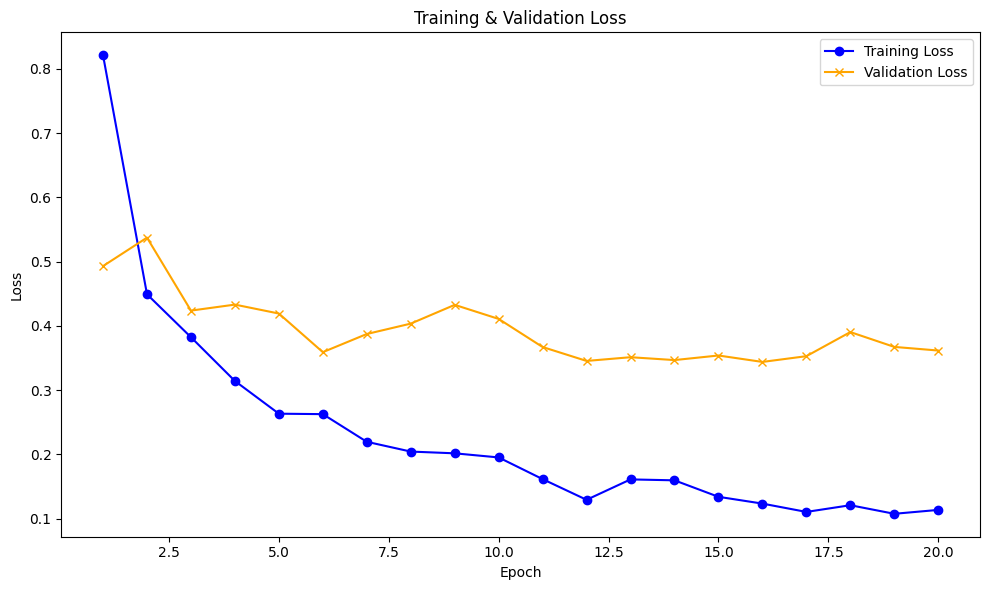

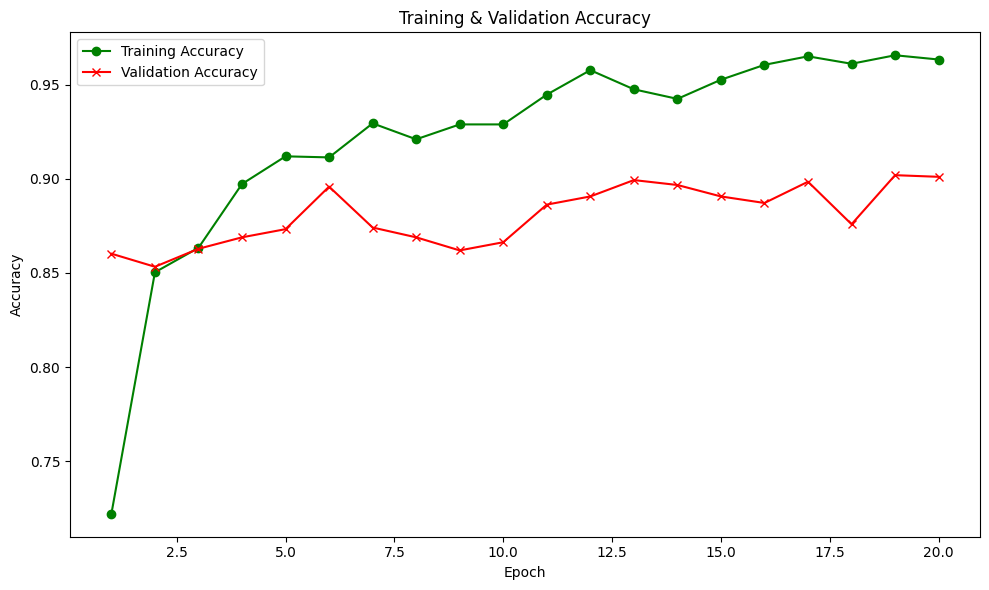

In [32]:
# Load the best model info
best_model_info = torch.load('EfficientNetB5_best_model.pth')

# Extract the metrics from the loaded model info
training_losses = best_model_info['training_losses']
training_accuracies = best_model_info['training_accuracies']
validation_losses = best_model_info['validation_losses']
validation_accuracies = best_model_info['validation_accuracies']
num_epochs = len(training_losses)

# Define the epochs array
epochs = np.arange(1, num_epochs + 1)

# Define the colors for the plot
color_loss = 'blue'
color_val_loss = 'orange'
color_acc = 'green'
color_val_acc = 'red'

# Plot for Loss
plt.figure(figsize=(10, 6))
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, training_losses, label='Training Loss', marker='o', color=color_loss)
plt.plot(epochs, validation_losses, label='Validation Loss', marker='x', color=color_val_loss)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for Accuracy
plt.figure(figsize=(10, 6))
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs, training_accuracies, label='Training Accuracy', marker='o', color=color_acc)
plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='x', color=color_val_acc)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# Load the best model from the saved state dictionary
num_classes = 6
categories = ['Trash', 'Plastic', 'Paper', 'Metal', 'Glass', 'Cardboard']
best_model = initialize_model(num_classes)
best_model.load_state_dict(best_model_info['state_dict'])

# load the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Assuming device setup is already done (use CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

# Call the misclassified_labels function
misclassified_samples = misclassified_labels(best_model, test_dataloader, device)

# Print some of the misclassified samples to verify
for sample in misclassified_samples[:100]:  # Just print the first 10 misclassified samples
    print(f"Image Path: {sample[0]}, Actual Label: {categories[sample[1]]}, Predicted Label: {categories[sample[2]]}")

Image Path: ../../data/dataset-resized\Trash\trash129.jpg, Actual Label: Trash, Predicted Label: Plastic
Image Path: ../../data/dataset-resized\Trash\trash98.jpg, Actual Label: Trash, Predicted Label: Paper
Image Path: ../../data/dataset-resized\Plastic\plastic465.jpg, Actual Label: Plastic, Predicted Label: Paper
Image Path: ../../data/dataset-resized\Glass\glass288.jpg, Actual Label: Glass, Predicted Label: Plastic
Image Path: ../../data/dataset-resized\Plastic\plastic413.jpg, Actual Label: Plastic, Predicted Label: Glass
Image Path: ../../data/dataset-resized\Cardboard\cardboard366.jpg, Actual Label: Cardboard, Predicted Label: Plastic
Image Path: ../../data/dataset-resized\Metal\metal296.jpg, Actual Label: Metal, Predicted Label: Glass
Image Path: ../../data/dataset-resized\Glass\glass286.jpg, Actual Label: Paper, Predicted Label: Cardboard
Image Path: ../../data/dataset-resized\Paper\paper44.jpg, Actual Label: Paper, Predicted Label: Trash
Image Path: ../../data/dataset-resized\Gl